In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df_raw = pd.read_csv("wdbc.csv", header=None)
df_raw

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
device = "cpu"
y = pd.get_dummies(df_raw.iloc[:,1:2])
y = torch.Tensor(y.values).to(device)



In [4]:
x = df_raw.iloc[:,2:]

x = (x - x.min()) / (x.max() - x.min())

x = torch.Tensor(x.values).to(device)

x

tensor([[0.5210, 0.0227, 0.5460,  ..., 0.9120, 0.5985, 0.4189],
        [0.6431, 0.2726, 0.6158,  ..., 0.6392, 0.2336, 0.2229],
        [0.6015, 0.3903, 0.5957,  ..., 0.8351, 0.4037, 0.2134],
        ...,
        [0.4553, 0.6212, 0.4458,  ..., 0.4873, 0.1287, 0.1519],
        [0.6446, 0.6635, 0.6655,  ..., 0.9107, 0.4971, 0.4523],
        [0.0369, 0.5015, 0.0285,  ..., 0.0000, 0.2574, 0.1007]])

In [5]:
class Autoencoder(nn.Module):
    # Layers is an array of integers representing the encoder architecture
    # Example: 30 --> 3 --> 30: layers = [30, 3]
    def __init__(self, layers):
        super().__init__()
        self.in_dim = layers[0]
        self.activation = nn.Sigmoid()
        self.layers = layers
        
        # Encoder
        self.encoder_layers = []
        
        for i in range(len(layers) - 1):
            self.encoder_layers.append(nn.Linear(layers[i], layers[i+1]))
            self.encoder_layers.append(nn.Sigmoid())
        
        self.encoder_sequence = nn.Sequential(*self.encoder_layers)
            
        # Decoder
        self.decoder_layers = []
        
#         for i in range(len(layers) - 1, 0, -1):
#             self.decoder_layers.append(nn.Linear(layers[i], layers[i - 1]))
#             self.decoder_layers.append(nn.Sigmoid())
    
#         layers.reverse()
#         for i in range(len(layers) - 1):
#             self.decoder_layers.append(nn.Linear(layers[i], layers[i+1]))
#             self.decoder_layers.append(nn.Sigmoid())

        reversed_layers = sorted(layers, reverse=False)
        for i in range(len(reversed_layers) - 1):
            self.decoder_layers.append(nn.Linear(reversed_layers[i], reversed_layers[i+1]))
            self.decoder_layers.append(nn.Sigmoid())
        
        self.decoder_sequence = nn.Sequential(*self.decoder_layers)
        
    def encode(self, x):
        return self.encoder_sequence(x)
    
    def decode(self, x):
        return self.decoder_sequence(x)
    
    def forward(self, x):
        x = self.encode(x)
        y = self.decode(x)
        return y

In [6]:
model = Autoencoder([30,20,10])

print(model)

Autoencoder(
  (activation): Sigmoid()
  (encoder_sequence): Sequential(
    (0): Linear(in_features=30, out_features=20, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): Sigmoid()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Sigmoid()
  )
)


In [7]:
learning_rate = 0.0001


loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 5

In [8]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [9]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
#     state = { 'state_dict': model.state_dict() }

#     torch.save(state, "autoencoder.pth")

Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 319.14it/s, loss=0.0896]


Ave Loss: 0.10493430011627967
Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 313.39it/s, loss=0.0794]


Ave Loss: 0.08985910502572854
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 314.80it/s, loss=0.071]


Ave Loss: 0.07711686651434815
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 315.05it/s, loss=0.0639]


Ave Loss: 0.06605245359241962
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 318.49it/s, loss=0.0582]


Ave Loss: 0.056472439416929296
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 355.32it/s, loss=0.0538]


Ave Loss: 0.048346663335044136
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 350.28it/s, loss=0.0505]


Ave Loss: 0.041650655254590926
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 315.47it/s, loss=0.0483]


Ave Loss: 0.03631449864948528
Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 328.11it/s, loss=0.0469]


Ave Loss: 0.03220557882205436
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 325.63it/s, loss=0.046]


Ave Loss: 0.029136999314160722
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 290.66it/s, loss=0.0456]


Ave Loss: 0.02689828746543642
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 283.66it/s, loss=0.0454]


Ave Loss: 0.025288813575906188
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 335.39it/s, loss=0.0454]


Ave Loss: 0.024138978788661853
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 360.71it/s, loss=0.0454]


Ave Loss: 0.023316899812862016
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 329.50it/s, loss=0.0454]


Ave Loss: 0.022725532517621393
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 340.95it/s, loss=0.0455]


Ave Loss: 0.022295866619076645
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 341.47it/s, loss=0.0456]


Ave Loss: 0.021979767339009987
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 316.35it/s, loss=0.0456]


Ave Loss: 0.02174395777023675
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 356.60it/s, loss=0.0457]


Ave Loss: 0.021565476318069716
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 348.49it/s, loss=0.0457]


Ave Loss: 0.021428429701349193
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 342.87it/s, loss=0.0457]


Ave Loss: 0.021321742852594246
Epoch: 21


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 364.89it/s, loss=0.0457]


Ave Loss: 0.021237622668737906
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 347.41it/s, loss=0.0458]


Ave Loss: 0.021170514774623148
Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 369.90it/s, loss=0.0458]


Ave Loss: 0.021116405733648622
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 362.93it/s, loss=0.0458]


Ave Loss: 0.021072348473560914
Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 355.57it/s, loss=0.0458]


Ave Loss: 0.021036144627846386
Epoch: 26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 343.89it/s, loss=0.0458]


Ave Loss: 0.021006127100503237
Epoch: 27


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 377.92it/s, loss=0.0458]


Ave Loss: 0.020981014167007647
Epoch: 28


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 351.53it/s, loss=0.0458]


Ave Loss: 0.020959803630320125
Epoch: 29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 349.93it/s, loss=0.0458]


Ave Loss: 0.020941705777914377
Epoch: 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 345.64it/s, loss=0.0458]


Ave Loss: 0.020926086362778096
Epoch: 31


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 363.06it/s, loss=0.0458]


Ave Loss: 0.02091243245900331
Epoch: 32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 332.05it/s, loss=0.0458]


Ave Loss: 0.020900324301532748
Epoch: 33


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 363.45it/s, loss=0.0458]


Ave Loss: 0.020889413992367815
Epoch: 34


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 366.62it/s, loss=0.0457]


Ave Loss: 0.020879409161576053
Epoch: 35


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 349.24it/s, loss=0.0457]


Ave Loss: 0.020870062208064553
Epoch: 36


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 347.25it/s, loss=0.0457]


Ave Loss: 0.02086115813111527
Epoch: 37


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 365.85it/s, loss=0.0457]


Ave Loss: 0.020852510004484077
Epoch: 38


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 355.56it/s, loss=0.0457]


Ave Loss: 0.020843950198277048
Epoch: 39


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 347.06it/s, loss=0.0457]


Ave Loss: 0.020835326947761995
Epoch: 40


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 357.20it/s, loss=0.0457]


Ave Loss: 0.020826501477705806
Epoch: 41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 354.23it/s, loss=0.0456]


Ave Loss: 0.02081734220611683
Epoch: 42


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 351.99it/s, loss=0.0456]


Ave Loss: 0.020807726974517368
Epoch: 43


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 369.72it/s, loss=0.0456]


Ave Loss: 0.02079753746000821
Epoch: 44


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 356.70it/s, loss=0.0456]


Ave Loss: 0.020786662275592487
Epoch: 45


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 364.07it/s, loss=0.0455]


Ave Loss: 0.02077499397605527
Epoch: 46


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 357.27it/s, loss=0.0455]


Ave Loss: 0.020762432758745394
Epoch: 47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 370.13it/s, loss=0.0455]


Ave Loss: 0.020748886018337912
Epoch: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 362.28it/s, loss=0.0454]


Ave Loss: 0.02073427123475101
Epoch: 49


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 344.23it/s, loss=0.0454]


Ave Loss: 0.020718518003265848
Epoch: 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 357.29it/s, loss=0.0453]


Ave Loss: 0.02070157061608737
Epoch: 51


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 368.59it/s, loss=0.0453]


Ave Loss: 0.020683390831803542
Epoch: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 368.52it/s, loss=0.0452]


Ave Loss: 0.02066395995452216
Epoch: 53


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 355.54it/s, loss=0.0452]


Ave Loss: 0.020643281064143305
Epoch: 54


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 371.08it/s, loss=0.0451]


Ave Loss: 0.02062137977203779
Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 364.74it/s, loss=0.045]


Ave Loss: 0.020598303861589284
Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 374.78it/s, loss=0.045]


Ave Loss: 0.020574123954008285
Epoch: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 348.14it/s, loss=0.0449]


Ave Loss: 0.020548928578041102
Epoch: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 359.96it/s, loss=0.0448]


Ave Loss: 0.0205228221357653
Epoch: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 357.05it/s, loss=0.0448]


Ave Loss: 0.020495919253383028
Epoch: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 341.50it/s, loss=0.0447]


Ave Loss: 0.020468339924455473
Epoch: 61


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 334.60it/s, loss=0.0446]


Ave Loss: 0.020440203497153624
Epoch: 62


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 343.06it/s, loss=0.0445]


Ave Loss: 0.020411624266815028
Epoch: 63


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 364.42it/s, loss=0.0445]


Ave Loss: 0.020382706488466316
Epoch: 64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 324.78it/s, loss=0.0444]


Ave Loss: 0.020353541550177493
Epoch: 65


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 329.24it/s, loss=0.0443]


Ave Loss: 0.020324206396349166
Epoch: 66


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 303.89it/s, loss=0.0443]


Ave Loss: 0.020294762118474433
Epoch: 67


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 332.69it/s, loss=0.0442]


Ave Loss: 0.020265253738647227
Epoch: 68


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 307.33it/s, loss=0.0441]


Ave Loss: 0.020235712468428046
Epoch: 69


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 342.92it/s, loss=0.0441]


Ave Loss: 0.02020615450792799
Epoch: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 338.15it/s, loss=0.044]


Ave Loss: 0.02017658386836972
Epoch: 71


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 315.45it/s, loss=0.0439]


Ave Loss: 0.020146993613850913
Epoch: 72


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 335.54it/s, loss=0.0439]


Ave Loss: 0.020117366866192275
Epoch: 73


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 342.52it/s, loss=0.0438]


Ave Loss: 0.02008767795683653
Epoch: 74


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 341.15it/s, loss=0.0437]


Ave Loss: 0.020057891585390297
Epoch: 75


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 347.30it/s, loss=0.0437]


Ave Loss: 0.02002796393884509
Epoch: 76


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 344.59it/s, loss=0.0436]


Ave Loss: 0.01999784082484742
Epoch: 77


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 332.98it/s, loss=0.0435]


Ave Loss: 0.01996745351342517
Epoch: 78


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 333.55it/s, loss=0.0435]


Ave Loss: 0.019936716682359315
Epoch: 79


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 339.37it/s, loss=0.0434]


Ave Loss: 0.019905521562976532
Epoch: 80


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 347.55it/s, loss=0.0433]


Ave Loss: 0.01987373558069138
Epoch: 81


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 345.62it/s, loss=0.0433]


Ave Loss: 0.019841209188789913
Epoch: 82


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 326.63it/s, loss=0.0432]


Ave Loss: 0.01980779742773034
Epoch: 83


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 334.40it/s, loss=0.0431]


Ave Loss: 0.019773390336092888
Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 347.04it/s, loss=0.043]


Ave Loss: 0.019737930098352462
Epoch: 85


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 361.37it/s, loss=0.0429]


Ave Loss: 0.01970140565301112
Epoch: 86


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 318.74it/s, loss=0.0428]


Ave Loss: 0.01966383763213168
Epoch: 87


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 318.76it/s, loss=0.0428]


Ave Loss: 0.01962525734122385
Epoch: 88


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 334.31it/s, loss=0.0427]


Ave Loss: 0.019585698136340892
Epoch: 89


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 331.18it/s, loss=0.0426]


Ave Loss: 0.019545188590296005
Epoch: 90


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 348.56it/s, loss=0.0425]


Ave Loss: 0.01950375173289917
Epoch: 91


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 327.99it/s, loss=0.0424]


Ave Loss: 0.019461402689972727
Epoch: 92


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 315.84it/s, loss=0.0423]


Ave Loss: 0.019418150386691355
Epoch: 93


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 327.53it/s, loss=0.0422]


Ave Loss: 0.019373999651227342
Epoch: 94


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 341.85it/s, loss=0.0421]


Ave Loss: 0.01932894932759697
Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 332.40it/s, loss=0.042]


Ave Loss: 0.01928299688734114
Epoch: 96


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 338.12it/s, loss=0.0419]


Ave Loss: 0.019236135921490035
Epoch: 97


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 328.15it/s, loss=0.0418]


Ave Loss: 0.019188357553885954
Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 335.10it/s, loss=0.0417]


Ave Loss: 0.019139652414116682
Epoch: 99


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 355.68it/s, loss=0.0416]

Ave Loss: 0.019090008550209172


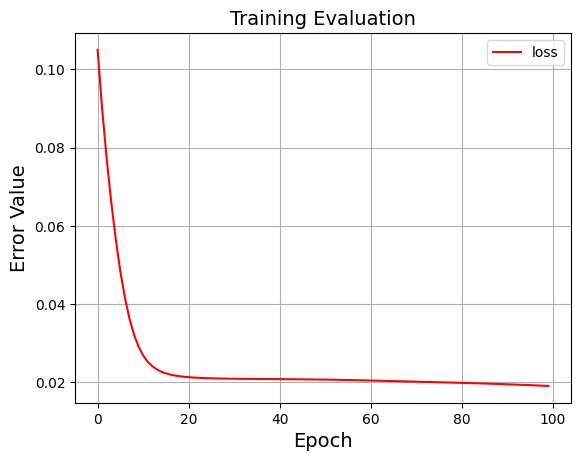

In [10]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [11]:
compressed_data = model.encode(x)

df_compressed_data = pd.DataFrame(compressed_data.detach().cpu().numpy())

df_compressed_data

,0,1,2,3,4,5,6,7,8,9
0,0.449244,0.436772,0.544210,0.467531,0.502148,0.512980,0.488424,0.537180,0.444859,0.427022
1,0.581249,0.567070,0.429137,0.587644,0.615073,0.615640,0.605073,0.645940,0.563160,0.549653
2,0.492165,0.478786,0.508216,0.506998,0.538830,0.545980,0.526808,0.571990,0.482653,0.464899
3,0.490048,0.479009,0.507750,0.509141,0.542446,0.547567,0.527432,0.574095,0.485211,0.466290
4,0.528701,0.516092,0.475185,0.540393,0.569430,0.573510,0.559297,0.602153,0.515278,0.500875
...,...,...,...,...,...,...,...,...,...,...
564,0.480304,0.467396,0.518222,0.495742,0.528815,0.536206,0.516154,0.561393,0.471727,0.454584
565,0.545062,0.531777,0.460528,0.555998,0.588315,0.589984,0.574367,0.617361,0.532787,0.514530
566,0.620592,0.612147,0.386231,0.628634,0.659430,0.654004,0.644351,0.685180,0.608566,0.595991
567,0.440016,0.427620,0.551242,0.459375,0.496087,0.507700,0.480287,0.530993,0.438002,0.419118


### Neural Network

In [12]:
#yy = y.detach().cpu().numpy()
y_raw = pd.get_dummies(df_raw.iloc[:,1:2])
df_compressed_data2 = pd.concat([df_compressed_data, y_raw], axis=1)
df_compressed_data2


,0,1,2,3,4,5,6,7,8,9,1_B,1_M
0,0.449244,0.436772,0.544210,0.467531,0.502148,0.512980,0.488424,0.537180,0.444859,0.427022,0,1
1,0.581249,0.567070,0.429137,0.587644,0.615073,0.615640,0.605073,0.645940,0.563160,0.549653,0,1
2,0.492165,0.478786,0.508216,0.506998,0.538830,0.545980,0.526808,0.571990,0.482653,0.464899,0,1
3,0.490048,0.479009,0.507750,0.509141,0.542446,0.547567,0.527432,0.574095,0.485211,0.466290,0,1
4,0.528701,0.516092,0.475185,0.540393,0.569430,0.573510,0.559297,0.602153,0.515278,0.500875,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.480304,0.467396,0.518222,0.495742,0.528815,0.536206,0.516154,0.561393,0.471727,0.454584,0,1
565,0.545062,0.531777,0.460528,0.555998,0.588315,0.589984,0.574367,0.617361,0.532787,0.514530,0,1
566,0.620592,0.612147,0.386231,0.628634,0.659430,0.654004,0.644351,0.685180,0.608566,0.595991,0,1
567,0.440016,0.427620,0.551242,0.459375,0.496087,0.507700,0.480287,0.530993,0.438002,0.419118,0,1


In [13]:
device = "cpu"
y = df_compressed_data2.iloc[:,10:12]
x = df_compressed_data2.iloc[:,0:10]
#x = torch.Tensor(x.values).to(device)


In [14]:
#Train Test Split

#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

y_train = torch.Tensor(y_train.values)
x_train = torch.Tensor(x_train.values)


In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 5) # input to first hidden layer        
        self.hidden_layer_2 = nn.Linear(5, 2) 
        
#         self.multiple_layers = nn.Sequential(
#             nn.Linear(10, 10),
#             nn.Sigmoid(),
#             nn.Linear(10, 10),
#             nn.Sigmoid(),
#             nn.Linear(10, 10),
#             nn.Sigmoid(),
#             nn.Linear(10, 10),
#             nn.Sigmoid(),
#         )
        
        self.output_layer = nn.Linear(2, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.activation(x)
        
        x = self.hidden_layer_2(x)
        x = self.activation(x)
        
        y = self.output_layer(x)
        y = self.activation(y)
        
        return y

In [16]:
model = NeuralNetwork(10, 2)

# Test structure of model
predictions = model.forward(x_train)

In [17]:
#learning_rate = 0.0001 #63%
learning_rate = 0.001

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 5

In [18]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset_2(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [19]:
def train_fn_2(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset_2(x=x_train, y=y_train)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn_2(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    #state = { 'state_dict': model.state_dict() }

    #torch.save(state, "model.pth")

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 342.33it/s, loss=0.243]


Ave Loss: 0.23985809480750953
Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 332.85it/s, loss=0.241]


Ave Loss: 0.23654048652439327
Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 355.32it/s, loss=0.24]


Ave Loss: 0.23469901592521877
Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 350.80it/s, loss=0.239]


Ave Loss: 0.23374509958775488
Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 341.50it/s, loss=0.239]


Ave Loss: 0.23321338636534555
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 346.76it/s, loss=0.238]


Ave Loss: 0.23285402554077106
Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 348.84it/s, loss=0.238]


Ave Loss: 0.23254545671599253
Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 360.69it/s, loss=0.238]


Ave Loss: 0.23222693850050916
Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 354.00it/s, loss=0.237]


Ave Loss: 0.2318644438471113
Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 364.60it/s, loss=0.236]


Ave Loss: 0.23143465849724446
Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 349.56it/s, loss=0.236]


Ave Loss: 0.23091752123046708
Epoch: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 361.19it/s, loss=0.235]


Ave Loss: 0.23029282017723546
Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 341.62it/s, loss=0.233]


Ave Loss: 0.22953891541276658
Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 351.44it/s, loss=0.232]


Ave Loss: 0.22863259846037562
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 357.60it/s, loss=0.23]


Ave Loss: 0.22754949789780837
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 393.08it/s, loss=0.228]


Ave Loss: 0.22626477234311157
Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 339.33it/s, loss=0.226]


Ave Loss: 0.2247539303459964
Epoch: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 333.34it/s, loss=0.223]


Ave Loss: 0.222993865609169
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 351.57it/s, loss=0.22]


Ave Loss: 0.22096396032925492
Epoch: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 365.27it/s, loss=0.217]


Ave Loss: 0.21864733132687245
Epoch: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 373.78it/s, loss=0.213]


Ave Loss: 0.21603217090551668
Epoch: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 389.35it/s, loss=0.208]


Ave Loss: 0.213112901364054
Epoch: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 382.45it/s, loss=0.204]


Ave Loss: 0.209891245669716
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 377.67it/s, loss=0.199]


Ave Loss: 0.20637681294273544
Epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 386.58it/s, loss=0.193]


Ave Loss: 0.20258713996672367
Epoch: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 369.80it/s, loss=0.187]


Ave Loss: 0.19854708269729718
Epoch: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 371.28it/s, loss=0.181]


Ave Loss: 0.19428762973664881
Epoch: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 361.65it/s, loss=0.175]


Ave Loss: 0.18984425035151806
Epoch: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 371.57it/s, loss=0.169]


Ave Loss: 0.18525503780488128
Epoch: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 358.75it/s, loss=0.162]


Ave Loss: 0.1805588899405448
Epoch: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 373.56it/s, loss=0.156]


Ave Loss: 0.17579388323720996
Epoch: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 347.42it/s, loss=0.149]


Ave Loss: 0.17099607870965214
Epoch: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 353.55it/s, loss=0.143]


Ave Loss: 0.16619864773455556
Epoch: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 350.26it/s, loss=0.136]


Ave Loss: 0.16143143786997585
Epoch: 34


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 368.52it/s, loss=0.13]


Ave Loss: 0.15672071351782307
Epoch: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 372.42it/s, loss=0.124]


Ave Loss: 0.15208924741862895
Epoch: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 363.72it/s, loss=0.118]


Ave Loss: 0.14755640387698843
Epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 374.29it/s, loss=0.113]


Ave Loss: 0.14313838213354677
Epoch: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 359.93it/s, loss=0.107]


Ave Loss: 0.1388484601872963
Epoch: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 375.86it/s, loss=0.102]


Ave Loss: 0.134697206727751
Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 365.57it/s, loss=0.0969]


Ave Loss: 0.13069279148028448
Epoch: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 405.91it/s, loss=0.092]


Ave Loss: 0.12684115857540906
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 355.73it/s, loss=0.0874]


Ave Loss: 0.12314629092157542
Epoch: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 367.74it/s, loss=0.083]


Ave Loss: 0.11961037108858863
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 347.63it/s, loss=0.0788]


Ave Loss: 0.11623405771596092
Epoch: 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 359.52it/s, loss=0.0749]


Ave Loss: 0.11301663151563524
Epoch: 46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 358.09it/s, loss=0.0711]


Ave Loss: 0.10995619897577134
Epoch: 47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 369.49it/s, loss=0.0675]


Ave Loss: 0.10704988515475294
Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 376.30it/s, loss=0.0641]


Ave Loss: 0.10429399878114134
Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 385.64it/s, loss=0.0609]


Ave Loss: 0.10168417318017928
Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 393.29it/s, loss=0.0579]


Ave Loss: 0.09921552689111494
Epoch: 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 386.45it/s, loss=0.055]


Ave Loss: 0.09688279538282327
Epoch: 52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 390.29it/s, loss=0.0523]


Ave Loss: 0.09468044806271791
Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 397.76it/s, loss=0.0498]


Ave Loss: 0.09260276653855057
Epoch: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 385.31it/s, loss=0.0474]


Ave Loss: 0.09064394978622159
Epoch: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 389.03it/s, loss=0.0451]


Ave Loss: 0.08879820424244626
Epoch: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 371.87it/s, loss=0.043]


Ave Loss: 0.08705977072100063
Epoch: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 348.02it/s, loss=0.041]


Ave Loss: 0.08542299174427331
Epoch: 58


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 374.19it/s, loss=0.0391]


Ave Loss: 0.08388235720877464
Epoch: 59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 392.33it/s, loss=0.0373]


Ave Loss: 0.08243251006518092
Epoch: 60


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 377.42it/s, loss=0.0356]


Ave Loss: 0.0810683028629193
Epoch: 61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 327.32it/s, loss=0.034]


Ave Loss: 0.07978477242024062
Epoch: 62


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 318.15it/s, loss=0.0325]


Ave Loss: 0.07857720216142607
Epoch: 63


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 333.16it/s, loss=0.0311]


Ave Loss: 0.07744106240979917
Epoch: 64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 352.99it/s, loss=0.0298]


Ave Loss: 0.07637208457626812
Epoch: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 383.19it/s, loss=0.0285]


Ave Loss: 0.07536619709252002
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 371.61it/s, loss=0.0273]


Ave Loss: 0.07441957466365708
Epoch: 67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 381.95it/s, loss=0.0262]


Ave Loss: 0.07352857139207176
Epoch: 68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 384.46it/s, loss=0.0251]


Ave Loss: 0.07268978636404806
Epoch: 69


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 383.16it/s, loss=0.0241]


Ave Loss: 0.07189998411890733
Epoch: 70


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 376.32it/s, loss=0.0232]


Ave Loss: 0.07115615689922329
Epoch: 71


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 373.19it/s, loss=0.0223]


Ave Loss: 0.07045545297992098
Epoch: 72


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 396.72it/s, loss=0.0214]


Ave Loss: 0.06979520650641931
Epoch: 73


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 375.76it/s, loss=0.0206]


Ave Loss: 0.06917291680084807
Epoch: 74


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 369.75it/s, loss=0.0199]


Ave Loss: 0.06858624344957727
Epoch: 75


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 368.64it/s, loss=0.0191]


Ave Loss: 0.06803298903281217
Epoch: 76


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 388.88it/s, loss=0.0185]


Ave Loss: 0.06751108597861705
Epoch: 77


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 392.79it/s, loss=0.0178]


Ave Loss: 0.0670186092995189
Epoch: 78


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 376.20it/s, loss=0.0172]


Ave Loss: 0.06655376213142178
Epoch: 79


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 383.98it/s, loss=0.0166]


Ave Loss: 0.0661148356816189
Epoch: 80


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 364.52it/s, loss=0.0161]


Ave Loss: 0.06570024864625308
Epoch: 81


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 362.34it/s, loss=0.0155]


Ave Loss: 0.06530852336948226
Epoch: 82


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 374.36it/s, loss=0.015]


Ave Loss: 0.06493827777884
Epoch: 83


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 374.88it/s, loss=0.0146]


Ave Loss: 0.06458820660526936
Epoch: 84


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 359.40it/s, loss=0.0141]


Ave Loss: 0.06425709180933024
Epoch: 85


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 374.02it/s, loss=0.0137]


Ave Loss: 0.06394379612846443
Epoch: 86


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 377.84it/s, loss=0.0133]


Ave Loss: 0.06364725334928013
Epoch: 87


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 365.91it/s, loss=0.0129]


Ave Loss: 0.06336646703082127
Epoch: 88


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 381.65it/s, loss=0.0125]


Ave Loss: 0.06310050258320848
Epoch: 89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 367.66it/s, loss=0.0121]


Ave Loss: 0.06284847427261891
Epoch: 90


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 367.81it/s, loss=0.0118]


Ave Loss: 0.06260957260319329
Epoch: 91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 358.52it/s, loss=0.0115]


Ave Loss: 0.06238300814088639
Epoch: 92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 378.94it/s, loss=0.0112]


Ave Loss: 0.06216808163898659
Epoch: 93


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 372.55it/s, loss=0.0109]


Ave Loss: 0.06196410594774144
Epoch: 94


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 389.03it/s, loss=0.0106]


Ave Loss: 0.06177045023171129
Epoch: 95


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 358.03it/s, loss=0.0103]


Ave Loss: 0.06158652824380404
Epoch: 96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 388.88it/s, loss=0.0101]


Ave Loss: 0.06141177062866288
Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 368.33it/s, loss=0.00983]


Ave Loss: 0.06124566391796119
Epoch: 98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 362.29it/s, loss=0.0096]


Ave Loss: 0.061087712967911593
Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 384.63it/s, loss=0.00937]

Ave Loss: 0.06093745221189418


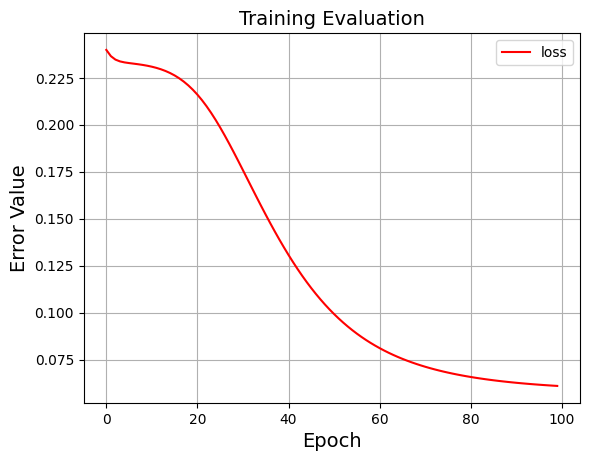

In [20]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [21]:
y_test = torch.Tensor(y_test.values)
x_test = torch.Tensor(x_test.values)

model = NeuralNetwork(10, 2)

predictions = model.forward(x_test)
preds = predictions.detach().cpu().numpy()

ohe = []
for i in preds:
       if i[0] > i[1]:
         ohe.append([1,0])
       else:
        ohe.append([0,1])
#preds
ohe

acc = accuracy_score(ohe, y_test)
cl_report = classification_report(ohe, y_test)
print("acc: ", acc)
print("cl report: ", cl_report)


acc:  0.631578947368421
cl report:                precision    recall  f1-score   support

           0       1.00      0.63      0.77       114
           1       0.00      0.00      0.00         0

   micro avg       0.63      0.63      0.63       114
   macro avg       0.50      0.32      0.39       114
weighted avg       1.00      0.63      0.77       114
 samples avg       0.63      0.63      0.63       114



D:\Data Engineering Class\Deep Learning\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
